In [72]:
# import necessary libraries
import pandas as pd
from datetime import datetime
import numpy as np

# read the original data
input_file = 'prosumer_daily_data1.csv'
print("Reading input file...")
df = pd.read_csv(input_file)

# store original shape for comparison
original_shape = df.shape
print(f"Original data shape: {original_shape}")

# display first few rows of original data for us to check
print("\nOriginal data sample:")
df.head()

Reading input file...
Original data shape: (180106, 6)

Original data sample:


,Customer,Postcode,date,GC,GG,net_load
0,11,2026,2010-07-01,26.873,6.743,20.130
1,11,2026,2010-07-02,20.961,1.977,18.984
2,11,2026,2010-07-03,37.023,7.305,29.718
3,11,2026,2010-07-04,31.955,6.573,25.382
4,11,2026,2010-07-05,34.751,1.378,33.373


In [74]:
# keep only the required columns
print("Keeping only required columns...")
columns_to_keep = ['Customer', 'Postcode', 'date']
df = df[columns_to_keep]

# display the data after keeping selected columns
print("\nData after keeping selected columns:")
df.head()

Keeping only required columns...

Data after keeping selected columns:


,Customer,Postcode,date
0,11,2026,2010-07-01
1,11,2026,2010-07-02
2,11,2026,2010-07-03
3,11,2026,2010-07-04
4,11,2026,2010-07-05


In [76]:
# convert dates to datetime
print("Converting dates...")
df['date'] = pd.to_datetime(df['date'])

# function to convert historical dates to 2024
def convert_to_2024(date):
    return date.replace(year=2024)

# function to convert early 2024 dates to 2025
def convert_early_dates_to_2025(date):
    if date.year == 2024:
        if date.month == 1 or (date.month == 2 and date.day <= 1):
            return date.replace(year=2025)
    return date

# apply date conversion
df['date'] = df['date'].apply(convert_to_2024)

# apply the conversion for early dates to 2025
df['date'] = df['date'].apply(convert_early_dates_to_2025)

# filter out dates outside our desired range cuz the api plan restriction
mask = (df['date'] >= '2024-02-05') & (df['date'] <= '2025-02-02')
df = df[mask]

# display sample after date conversion
print("\nData after date conversion:")
df.head()

Converting dates...

Data after date conversion:


,Customer,Postcode,date
0,11,2026,2024-07-01
1,11,2026,2024-07-02
2,11,2026,2024-07-03
3,11,2026,2024-07-04
4,11,2026,2024-07-05


In [78]:
# remove duplicates
print("Removing duplicates...")
df = df.drop_duplicates(subset=['Postcode', 'date'])

# sort by postcode and date
df = df.sort_values(['Postcode', 'date'])

# convert date back to string format
df['date'] = df['date'].dt.strftime('%Y-%m-%d')

# display sample of processed data
print("\nProcessed data sample:")
df.head()

Removing duplicates...

Processed data sample:


,Customer,Postcode,date
67075,116,2008,2024-02-05
67076,116,2008,2024-02-06
67077,116,2008,2024-02-07
67078,116,2008,2024-02-08
67079,116,2008,2024-02-09


In [80]:
# save processed data
output_file = '2024_weather_data_preprocessed.csv'
df.to_csv(output_file, index=False)

# print summary statistics
print("\nProcessing Summary:")
print(f"Original records: {original_shape[0]}")
print(f"Processed records: {len(df)}")
print(f"Unique postcodes: {df['Postcode'].nunique()}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")


Processing Summary:
Original records: 180106
Processed records: 28314
Unique postcodes: 78
Date range: 2024-02-05 to 2025-02-01


In [83]:
###### now creating a simulated one year 2024-2025 data set finished######

In [85]:
##### now we can extract latitude and longitude for this dataset  #####

In [88]:
# import necessary libraries
import pandas as pd
import requests
import time
import json
from datetime import datetime

# my api key
API_KEY = '023826bb6ba471680c4069db1a508424'

# read the preprocessed data
df = pd.read_csv('2024_weather_data_preprocessed.csv')
print("Data Analysis:")
print(f"Total rows: {len(df)}")
print(f"Unique postcodes: {df['Postcode'].nunique()}")
print(f"Unique date-postcode combinations: {len(df.groupby(['Postcode', 'date']).size())}")
print("\nSample of data:")
df.head()

# get unique postcodes and take a small sample
sample_size = 5  # let's test with 5 postcodes first
sample_postcodes = df['Postcode'].unique()[:sample_size]
sample_df = df[df['Postcode'].isin(sample_postcodes)].copy()

print(f"Sample Analysis:")
print(f"Number of postcodes in sample: {len(sample_postcodes)}")
print(f"Total rows in sample: {len(sample_df)}")
print(f"Unique date-postcode combinations in sample: {len(sample_df.groupby(['Postcode', 'date']).size())}")



Data Analysis:
Total rows: 28314
Unique postcodes: 78
Unique date-postcode combinations: 28314

Sample of data:
Sample Analysis:
Number of postcodes in sample: 5
Total rows in sample: 1815
Unique date-postcode combinations in sample: 1815


In [90]:
# function to get coordinates for a postcode with print satements to showcase the processing status 
def get_coordinates(postcode, api_key):
    """get coordinates for Australian postcode using OpenWeatherMap API"""
    url = "http://api.openweathermap.org/geo/1.0/zip"
    params = {
        'zip': f"{postcode},AU",
        'appid': api_key
    }
    
    try:
        response = requests.get(url, params=params)
        print(f"Postcode {postcode} - Status Code: {response.status_code}")
        
        if response.status_code == 200:
            data = response.json()
            return {
                'Postcode': postcode,
                'latitude': data.get('lat'),
                'longitude': data.get('lon'),
                'success': True
            }
        else:
            print(f"Error response: {response.text}")
            return {
                'Postcode': postcode,
                'success': False,
                'error': response.text
            }
            
    except Exception as e:
        print(f"Exception for postcode {postcode}: {str(e)}")
        return {
            'Postcode': postcode,
            'success': False,
            'error': str(e)
        }

In [92]:
## try a small dataset for testing first 

In [94]:
# get coordinates for sample postcodes
results = []
print("Getting coordinates for sample postcodes...")

for postcode in sample_postcodes:
    print(f"\nProcessing postcode: {postcode}")
    result = get_coordinates(postcode, API_KEY)
    results.append(result)
    time.sleep(1)  # Rate limiting

coords_df = pd.DataFrame(results)
print("\nCoordinates results:")
coords_df

Getting coordinates for sample postcodes...

Processing postcode: 2008
Postcode 2008 - Status Code: 200

Processing postcode: 2010
Postcode 2010 - Status Code: 200

Processing postcode: 2018
Postcode 2018 - Status Code: 200

Processing postcode: 2021
Postcode 2021 - Status Code: 200

Processing postcode: 2025
Postcode 2025 - Status Code: 200

Coordinates results:


,Postcode,latitude,longitude,success
0,2008,-33.8860,151.1994,True
1,2010,-33.8777,151.2187,True
2,2018,-33.9155,151.2057,True
3,2021,-33.8927,151.2262,True
4,2025,-33.8869,151.2425,True


In [95]:
# then merge coordinates with sample data
if len(coords_df[coords_df['success'] == True]) > 0:
    # get successful coordinates
    coords_mapping = coords_df[coords_df['success'] == True][['Postcode', 'latitude', 'longitude']]
    
    # merge with sample data
    final_df = pd.merge(sample_df, coords_mapping, on='Postcode', how='left')
    
    # reorder columns
    final_df = final_df[['Customer', 'Postcode', 'date', 'latitude', 'longitude']]
    
    # save sample result
    final_df.to_csv('2024_weather_data_with_coords_sample.csv', index=False)
    
    print("\nFinal dataset sample:")
    print(final_df.head())
    
    print("\nFinal dataset analysis:")
    print(f"Total rows: {len(final_df)}")
    print(f"Unique postcodes: {final_df['Postcode'].nunique()}")
    print(f"Unique date-postcode combinations: {len(final_df.groupby(['Postcode', 'date']).size())}")
    print(f"Rows with coordinates: {len(final_df.dropna())}")


Final dataset sample:
   Customer  Postcode        date  latitude  longitude
0       116      2008  2024-02-05   -33.886   151.1994
1       116      2008  2024-02-06   -33.886   151.1994
2       116      2008  2024-02-07   -33.886   151.1994
3       116      2008  2024-02-08   -33.886   151.1994
4       116      2008  2024-02-09   -33.886   151.1994

Final dataset analysis:
Total rows: 1815
Unique postcodes: 5
Unique date-postcode combinations: 1815
Rows with coordinates: 1815


In [96]:
# calculate timing estimates for full dataset
total_rows = len(df)
unique_date_postcode_combinations = len(df.groupby(['Postcode', 'date']).size())
unique_postcodes = df['Postcode'].nunique()

print(f"\nFull Dataset Processing Estimates:")
print(f"Total rows in final dataset: {total_rows}")
print(f"Unique date-postcode combinations: {unique_date_postcode_combinations}")
print(f"Unique postcodes (API calls needed): {unique_postcodes}")

# estimate processing time for API calls
estimated_time = unique_postcodes  # about 1 second per postcode
print(f"\nEstimated processing time for geocoding API calls:")
print(f"- Seconds: {estimated_time}")
print(f"- Minutes: {estimated_time/60:.1f}")
print(f"- Hours: {estimated_time/3600:.2f}")


Full Dataset Processing Estimates:
Total rows in final dataset: 28314
Unique date-postcode combinations: 28314
Unique postcodes (API calls needed): 78

Estimated processing time for geocoding API calls:
- Seconds: 78
- Minutes: 1.3
- Hours: 0.02


In [98]:
# small dataset test successfully

In [99]:
# write a new get coordiantes function the only difference is that no print statements

In [100]:
# define the silent coordinates function
def get_coordinates_silent(postcode, api_key):
    """get coordinates for Australian postcode using OpenWeatherMap API - without prints"""
    url = "http://api.openweathermap.org/geo/1.0/zip"
    params = {
        'zip': f"{postcode},AU",
        'appid': api_key
    }
    
    try:
        response = requests.get(url, params=params)
        if response.status_code == 200:
            data = response.json()
            return {
                'Postcode': postcode,
                'latitude': data.get('lat'),
                'longitude': data.get('lon'),
                'success': True
            }
        else:
            return {
                'Postcode': postcode,
                'success': False,
                'error': response.text
            }
    except Exception as e:
        return {
            'Postcode': postcode,
            'success': False,
            'error': str(e)
        }

In [101]:
# now to process full dataset almost same steps like small sample dataset
from tqdm import tqdm

print("Processing full dataset...")

# read the full preprocessed dataset
full_df = pd.read_csv('2024_weather_data_preprocessed.csv')
print(f"Total rows in dataset: {len(full_df)}")

# get unique postcodes
unique_postcodes = full_df['Postcode'].unique()
print(f"Unique postcodes to process: {len(unique_postcodes)}")

# get coordinates for unique postcodes with progress bar
coords_results = []
pbar = tqdm(unique_postcodes, desc="Processing unique postcodes")

for postcode in pbar:
    result = get_coordinates_silent(postcode, API_KEY)
    coords_results.append(result)
    time.sleep(1)  # Rate limiting

# convert results to DataFrame
coords_df = pd.DataFrame(coords_results)
print("\nCoordinates retrieval complete")

# merge coordinates with full dataset
if len(coords_df[coords_df['success'] == True]) > 0:
    # Get successful coordinates
    coords_mapping = coords_df[coords_df['success'] == True][['Postcode', 'latitude', 'longitude']]
    
    # Merge with full dataset
    final_full_df = pd.merge(
        full_df, 
        coords_mapping, 
        on=['Postcode'], 
        how='left'
    )
    
    # reorder columns
    final_full_df = final_full_df[['Customer', 'Postcode', 'date', 'latitude', 'longitude']]
    
    # save complete dataset
    final_full_df.to_csv('2024_weather_data_with_coords_complete.csv', index=False)
    
    print(f"\nProcessing complete:")
    print(f"Total rows: {len(final_full_df)}")
    print(f"Rows with coordinates: {len(final_full_df.dropna())}")
    print(f"Success rate: {(len(final_full_df.dropna()) / len(final_full_df) * 100):.2f}%")

Processing full dataset...
Total rows in dataset: 28314
Unique postcodes to process: 78


Processing unique postcodes: 100%|██████████████| 78/78 [02:05<00:00,  1.61s/it]


Coordinates retrieval complete

Processing complete:
Total rows: 28314
Rows with coordinates: 28314
Success rate: 100.00%


In [108]:
# highlight, 经过实验得知，经纬度数据提取还蛮快的，因为只需要关注unique postcode就行而不是每一行，大大的加快了提取经纬度的速度

In [109]:
### now the full dataset is finished 

In [60]:
### i want to do the same steps for  the input file prosumer_daily_data1.csv

In [61]:
# 可以吧original dataset对应postcode的经纬度给提取出来，把经纬度放在postcode的旁边，也就是第三第四列

In [62]:
# Process full dataset efficiently
from tqdm import tqdm

print("Processing full dataset...")

# Read the full preprocessed dataset
full_df = pd.read_csv('prosumer_daily_data1.csv')
print(f"Total rows in dataset: {len(full_df)}")

# Get unique postcodes
unique_postcodes = full_df['Postcode'].unique()
print(f"Unique postcodes to process: {len(unique_postcodes)}")

# Get coordinates for unique postcodes with progress bar
coords_results = []
pbar = tqdm(unique_postcodes, desc="Processing unique postcodes")

for postcode in pbar:
    result = get_coordinates_silent(postcode, API_KEY)
    coords_results.append(result)
    time.sleep(1)  # Rate limiting

# Convert results to DataFrame
coords_df = pd.DataFrame(coords_results)
print("\nCoordinates retrieval complete")

# Merge coordinates with full dataset
if len(coords_df[coords_df['success'] == True]) > 0:
    # Get successful coordinates
    coords_mapping = coords_df[coords_df['success'] == True][['Postcode', 'latitude', 'longitude']]
    
    # Merge with full dataset
    final_full_df = pd.merge(
        full_df, 
        coords_mapping, 
        on=['Postcode'], 
        how='left'
    )
    
    # reorder columns so latitude and longitude are next to Postcode
    final_full_df = final_full_df[['Customer', 'Postcode', 'latitude', 'longitude', 'date']]

    
    # Save complete dataset
    final_full_df.to_csv('prosumer_daily_data1_withcoordinates.csv', index=False)
    
    print(f"\nProcessing complete:")
    print(f"Total rows: {len(final_full_df)}")
    print(f"Rows with coordinates: {len(final_full_df.dropna())}")
    print(f"Success rate: {(len(final_full_df.dropna()) / len(final_full_df) * 100):.2f}%")

Processing full dataset...
Total rows in dataset: 180106
Unique postcodes to process: 78


Processing unique postcodes: 100%|██████████████| 78/78 [01:35<00:00,  1.22s/it]


Coordinates retrieval complete

Processing complete:
Total rows: 180106
Rows with coordinates: 180106
Success rate: 100.00%


In [63]:
# now for the prosumer_daily_data1.csv, coordiantes can be extracted succeefully.

In [ ]:
# we are trying to extract the 2024 weather data for our 2024 sample data set

In [ ]:
# to test whether the weather data extraction can be done successfully 

In [ ]:
# use another file to write it, cuz so far codes are so long , but i still put same code down here 
# to make this is a full notebook to finish the coordiantes and weather data extraction

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import requests
import time
import json
import sqlite3
from pathlib import Path
from tqdm import tqdm
import asyncio
import aiohttp
import nest_asyncio
nest_asyncio.apply()  # this allows nested async loops

class WeatherDataProcessor:
    def __init__(self, api_key='023826bb6ba471680c4069db1a508424', cache_db='weather_cache.db', max_concurrent=5):
        self.api_key = api_key
        self.cache_db = cache_db
        self.max_concurrent = max_concurrent
        self.setup_cache()
        self.session = None
    
    def setup_cache(self):
        with sqlite3.connect(self.cache_db) as conn:
            conn.execute('''
                CREATE TABLE IF NOT EXISTS weather_cache (
                    location_date TEXT PRIMARY KEY,
                    weather_data TEXT,
                    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
                )
            ''')
            conn.execute('CREATE INDEX IF NOT EXISTS idx_location_date ON weather_cache(location_date)')

    async def get_weather_data(self, lat, lon, date_str):
        cache_key = f"{lat}_{lon}_{date_str}"
        
        # check cache first
        cached_weather = self._get_cached_weather(cache_key)
        if cached_weather:
            return cached_weather

        date = datetime.strptime(date_str, '%Y-%m-%d')
        timestamp = int(date.timestamp())
        
        url = "https://history.openweathermap.org/data/2.5/history/city"
        params = {
            'lat': lat,
            'lon': lon,
            'type': 'hour',
            'start': timestamp,
            'end': timestamp + 86400,
            'appid': self.api_key,
            'units': 'metric'
        }
        
        try:
            async with self.session.get(url, params=params) as response:
                if response.status == 200:
                    data = await response.json()
                    if data.get('list'):
                        weather_data = self._process_weather_data(data)
                        if weather_data:
                            self._cache_weather(cache_key, weather_data)
                        return weather_data
                return None
        except Exception as e:
            print(f"Error fetching weather data: {str(e)}")
            return None

    async def process_batch(self, batch_df):
        if self.session is None:
            self.session = aiohttp.ClientSession()

        weather_columns = ['temperature', 'humidity', 'wind_speed', 
                         'clouds', 'precipitation', 'pressure',
                         'weather_description', 'data_type']
        
        semaphore = asyncio.Semaphore(self.max_concurrent)
        
        async def process_row(row):
            async with semaphore:
                date_str = row['date'].strftime('%Y-%m-%d')
                weather_data = await self.get_weather_data(row['latitude'], row['longitude'], date_str)
                await asyncio.sleep(0.2)  # Rate limiting
                return row.name, weather_data

        tasks = [process_row(row) for _, row in batch_df.iterrows()]
        results = await asyncio.gather(*tasks)
        
        for idx, weather_data in results:
            if weather_data:
                for col in weather_columns:
                    batch_df.loc[idx, col] = weather_data.get(col)
        
        return batch_df

    async def process_all_data(self, df, batch_size):
        processed_dfs = []
        
        with tqdm(total=len(df), desc="Processing", unit="records") as pbar:
            for start_idx in range(0, len(df), batch_size):
                end_idx = min(start_idx + batch_size, len(df))
                batch = df.iloc[start_idx:end_idx].copy()
                
                processed_batch = await self.process_batch(batch)
                processed_dfs.append(processed_batch)
                
                pbar.update(len(batch))
                
                # Save interim results
                if len(processed_dfs) % 10 == 0:
                    interim_df = pd.concat(processed_dfs)
                    interim_df.to_csv(f'weather_data_interim_{len(processed_dfs)}.csv', index=False)
        
        if self.session:
            await self.session.close()
            self.session = None
            
        return pd.concat(processed_dfs)

    def process_by_date_range(self, input_file, start_date='2024-02-02', end_date='2025-02-01', batch_size=50):
        print(f"\nProcessing date range: {start_date} to {end_date}")
        
        # read and prepare data
        df = pd.read_csv(input_file)
        df['date'] = pd.to_datetime(df['date'])
        
        # filter date range
        mask = (df['date'] >= start_date) & (df['date'] <= end_date)
        df = df[mask].copy()
        
        total_records = len(df)
        print(f"\nTotal records to process: {total_records}")
        
        estimated_hours = (total_records * 0.2) / 3600
        print(f"Estimated processing time: {estimated_hours:.1f} hours\n")

        # process the data using asyncio
        loop = asyncio.get_event_loop()
        result_df = loop.run_until_complete(self.process_all_data(df, batch_size))
        
        return result_df

    def _process_weather_data(self, api_response):
        try:
            if not api_response.get('list'):
                return None
                
            daily_data = api_response['list'][0]
            weather_info = daily_data.get('weather', [{}])[0]
            
            return {
                'temperature': daily_data.get('main', {}).get('temp'),
                'feels_like': daily_data.get('main', {}).get('feels_like'),
                'humidity': daily_data.get('main', {}).get('humidity'),
                'pressure': daily_data.get('main', {}).get('pressure'),
                'wind_speed': daily_data.get('wind', {}).get('speed'),
                'clouds': daily_data.get('clouds', {}).get('all'),
                'precipitation': daily_data.get('rain', {}).get('1h', 0),
                'weather_description': weather_info.get('description'),
                'data_type': 'historical'
            }
        except Exception as e:
            print(f"Error processing weather data: {str(e)}")
            return None

    def _get_cached_weather(self, cache_key):
        with sqlite3.connect(self.cache_db) as conn:
            result = conn.execute(
                "SELECT weather_data FROM weather_cache WHERE location_date = ?",
                (cache_key,)
            ).fetchone()
            return json.loads(result[0]) if result else None

    def _cache_weather(self, cache_key, weather_data):
        with sqlite3.connect(self.cache_db) as conn:
            conn.execute(
                "INSERT OR REPLACE INTO weather_cache (location_date, weather_data) VALUES (?, ?)",
                (cache_key, json.dumps(weather_data))
            )

In [ ]:
# initialize the processor
processor = WeatherDataProcessor()

# process the data
result_df = processor.process_by_date_range(
    input_file='2024_weather_data_with_coords_complete.csv',
    start_date='2024-02-05',
    end_date='2025-02-01',
    batch_size=50  # Optimized batch size
)

# save the final results
result_df.to_csv('2024_weather_data_final.csv', index=False)

In [ ]:
# if all of above steps are good ,we can also think about creating some basic visualizations of the results
# we can try to do it after the data extraction complete and show some basic statistics of these weather data

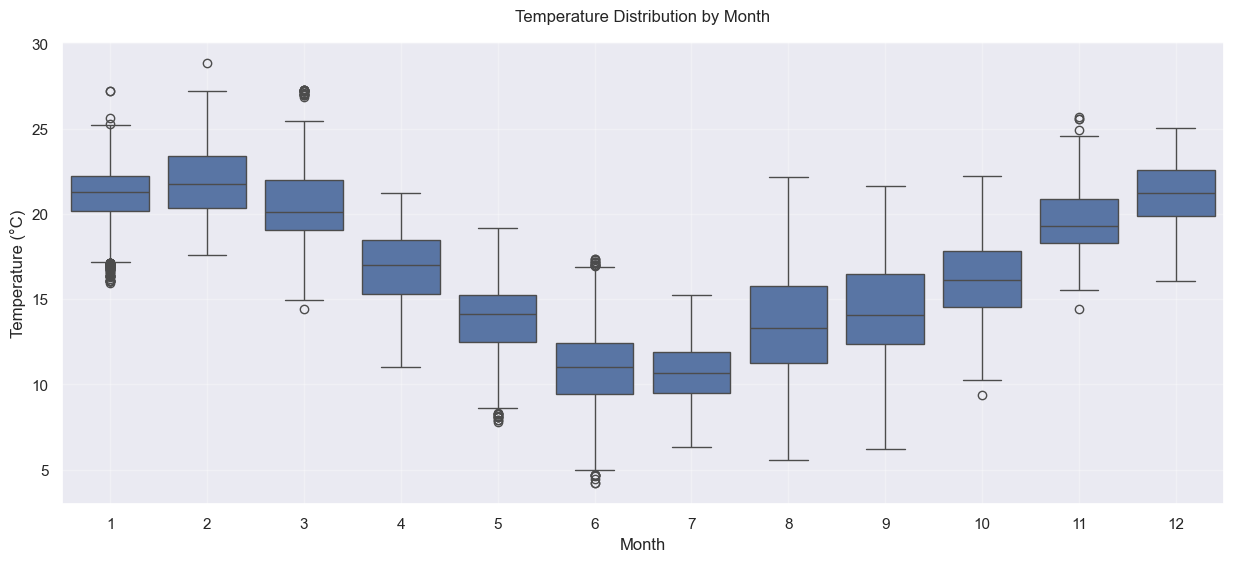

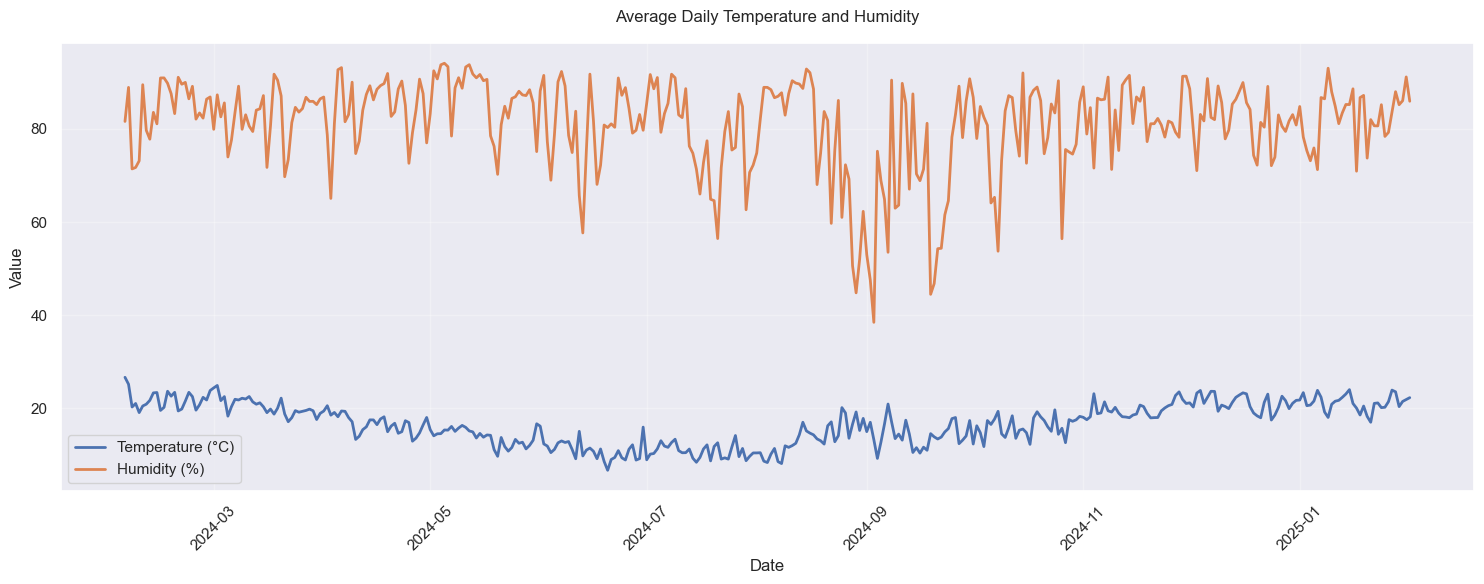

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# read the processed data
df = pd.read_csv('2024_weather_data_final.csv')
df['date'] = pd.to_datetime(df['date'])

# set simple style settings
plt.style.use('default')
sns.set_theme()

# temperature distribution over time
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x=df['date'].dt.month, y='temperature')
plt.title('Temperature Distribution by Month', fontsize=12, pad=15)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.show()

# average daily temperature and humidity
plt.figure(figsize=(15, 6))
daily_avg = df.groupby('date')[['temperature', 'humidity']].mean().reset_index()
plt.plot(daily_avg['date'], daily_avg['temperature'], label='Temperature (°C)', linewidth=2)
plt.plot(daily_avg['date'], daily_avg['humidity'], label='Humidity (%)', linewidth=2)
plt.title('Average Daily Temperature and Humidity', fontsize=12, pad=15)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


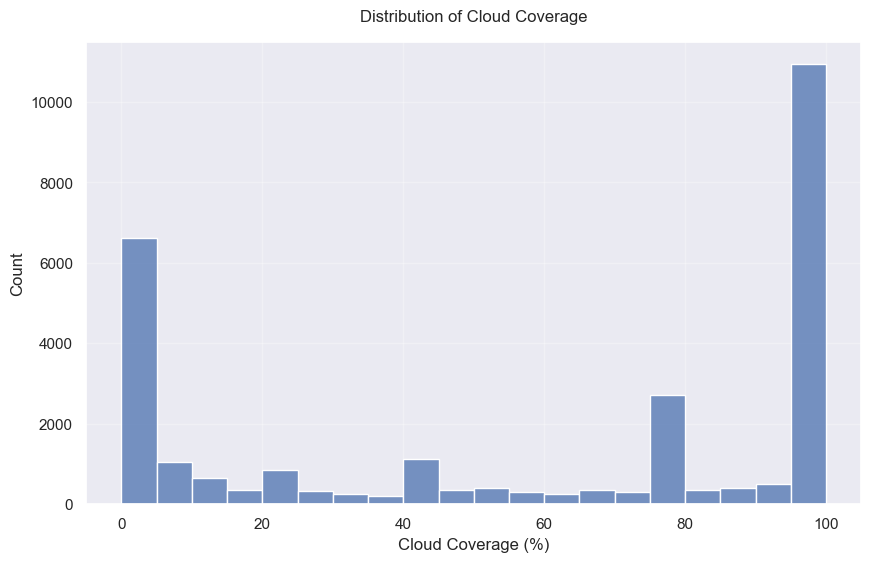

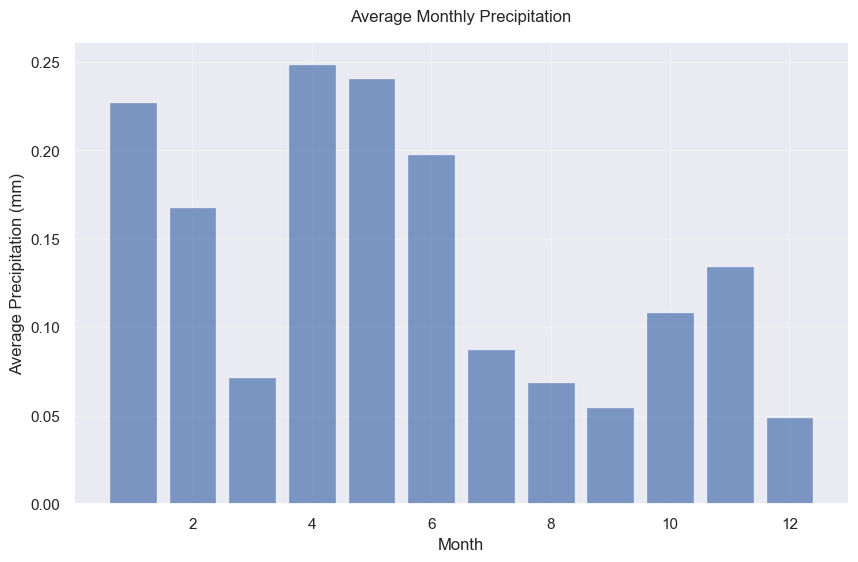

In [11]:
# cloud coverage distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='clouds', bins=20)
plt.title('Distribution of Cloud Coverage', fontsize=12, pad=15)
plt.xlabel('Cloud Coverage (%)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# monthly average precipitation
plt.figure(figsize=(10, 6))
monthly_precip = df.groupby(df['date'].dt.month)['precipitation'].mean()
plt.bar(monthly_precip.index, monthly_precip.values, alpha=0.7)
plt.title('Average Monthly Precipitation', fontsize=12, pad=15)
plt.xlabel('Month')
plt.ylabel('Average Precipitation (mm)')
plt.grid(True, alpha=0.3)
plt.show()

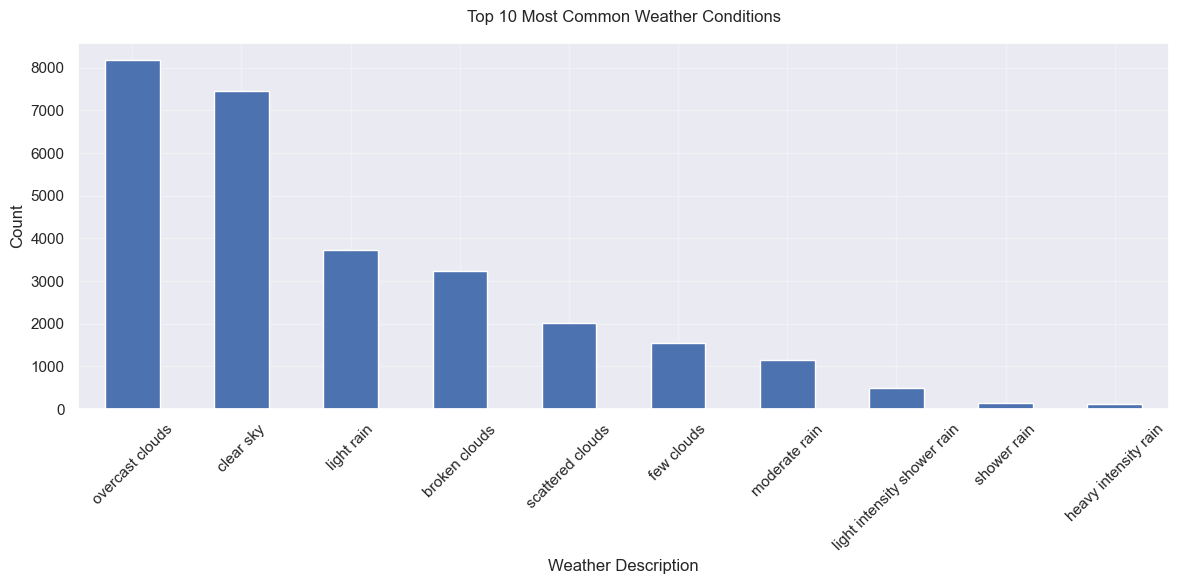

In [13]:
# T10 weather description distribution
plt.figure(figsize=(12, 6))
weather_counts = df['weather_description'].value_counts().head(10)
weather_counts.plot(kind='bar')
plt.title('Top 10 Most Common Weather Conditions', fontsize=12, pad=15)
plt.xlabel('Weather Description')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# print some basic statistics
print("\nBasic Weather Statistics:")
print("\nTemperature Statistics (°C):")
print(df['temperature'].describe().round(2))

print("\nHumidity Statistics (%):")
print(df['humidity'].describe().round(2))

print("\nWind Speed Statistics (m/s):")
print(df['wind_speed'].describe().round(2))


Basic Weather Statistics:

Temperature Statistics (°C):
count    28314.00
mean        16.67
std          4.45
min          4.20
25%         12.95
50%         17.21
75%         20.31
max         28.84
Name: temperature, dtype: float64

Humidity Statistics (%):
count    28314.00
mean        80.98
std         10.86
min         31.00
25%         76.00
50%         83.00
75%         88.00
max        100.00
Name: humidity, dtype: float64

Wind Speed Statistics (m/s):
count    28314.00
mean         3.34
std          2.54
min          0.00
25%          1.43
50%          2.68
75%          4.47
max         15.95
Name: wind_speed, dtype: float64


In [ ]:
注意：
当前的student plan去extract historical data只能提取当前时间过去一年的数据
当前进度：
准备分开写。
第一阶段：先通过geocoding api根据postcode把其对应的经纬度给提取出来，先用small sample测试一下，看看处理速度。如果很慢，就和提取天气数据一起进行。
highlight, 经过实验得知，经纬度数据提取还蛮快的，因为只需要关注unique postcode就行而不是每一行，大大的加快了提取经纬度的速度。
第二阶段：根据提取好的经纬度，去提取天气数据，因为我的student plan的局限性，先提取一年内的天气数据看看结果怎么样。
最后阶段：第二阶段完成后先汇报给fusen师兄，因为这个工作已经耽搁很久了，不能再拖后了，看看怎么提取2010到2013的historical weather data因为这个api的价格还蛮高的。

注意：
数据集的date是2010-2013年的，所以如果想提取2024年相同postcode对应的天气数据，我需要重新建一个数据集，Customer, Postcode和原来一致，但是gc,gg，netload列
先drop掉因为时间不一致，针对性不强。
所以新的数据集就是 Customer, Postcode, date. 时间范围是2024-02-02到2025-02-02.---->先把这一步完成掉，之后开始上面的步骤


进度：可以把original dataset对应postcode的经纬度给提取出来，把经纬度放在postcode的旁边，也就是第三第四列。